# A2C (train)
[Deep Reinforcement Learning with Policy Gradients and Actor-Critic Methods](https://www.datahubbs.com/policy-gradients-and-advantage-actor-critic/)  
[Two-Headed A2C Network in PyTorch](https://www.datahubbs.com/two-headed-a2c-network-in-pytorch/)

## 1. Setup

In [1]:
import config
import gym
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys

from collections import deque
from a2c import A2C
from preprocessing import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(f'sys.version: {sys.version}')
print(f'skimage.version: {skimage.__version__}')
print(f'tf.version: {tf.__version__}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
skimage.version: 0.14.1
tf.version: 1.11.0


## 2. Look at our env

In [2]:
env = gym.make(config.GAME_NAME)
state = env.reset()
print(f'Game: {config.GAME_NAME}')
print('A state (in env, not in our dqn) is represented by a frame')
print(type(state), state.dtype)
print(state.shape)

Game: Pong-v0
A state (in env, not in our dqn) is represented by a frame
<class 'numpy.ndarray'> uint8
(210, 160, 3)


In [3]:
print(f'Num_Actions: {env.action_space.n}')
action_meanings = env.unwrapped.get_action_meanings()
for i in range(env.action_space.n):
    print(f'{i}: {action_meanings[i]}')

Num_Actions: 6
0: NOOP
1: FIRE
2: RIGHT
3: LEFT
4: RIGHTFIRE
5: LEFTFIRE


__Look how the rgb frame is preprocessed__

initial: uint8
preprocessed_frame: uint8, [62, 236]


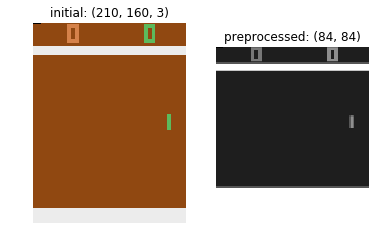

In [4]:
env.reset()
rgb_frame, _, _, _ = env.step(1)
preprocessed_frame = preprocess_frame(rgb_frame)

print(f'initial: {rgb_frame.dtype}')
print(f'preprocessed_frame: {preprocessed_frame.dtype}'
      f', [{preprocessed_frame.min()}, {preprocessed_frame.max()}]')

plt.figure()

plt.subplot(1, 2, 1)
plt.title(f'initial: {rgb_frame.shape}')
plt.axis('off')
plt.imshow(rgb_frame)

plt.subplot(1, 2, 2)
plt.title(f'preprocessed: {preprocessed_frame.shape}')
plt.axis('off')
plt.imshow(preprocessed_frame, cmap='gray')

plt.show()

## 3. A2C

### CNN architecture
1. Conv2d(filters=32, kernel_size=8, strides=4, padding='valid', activation=ReLU)
2. Conv2d(filters=64, kernel_size=4, strides=2, padding='valid', activation=ReLU)  
3. Conv2d(filters=64, kernel_size=3, strides=1, padding='valid', activation=ReLU) -> Flatten()  
4. FC(512, activation=ReLU)
5. Actor: FC(NUM_ACTIONS, activation=Linear) + Softmax()
5. Critic: FC(1, activation=Linear)

### Instantiate A2C net

In [5]:
tf.reset_default_graph()

a2c = A2C(action_size=env.action_space.n)

## 4. Training

### A2C (training algorithm)

In [6]:
def a2c_training(a2c, env):
    # to save some ckpts
    saver = tf.train.Saver(max_to_keep=50)
    
    with tf.Session() as sess:
        # init tf variables
        sess.run(tf.global_variables_initializer())
        
        # some vars for train_stats
        step = 0
        iters_per_episode = []
        reward_per_episode = []
        actor_loss_per_iter = []
        critic_loss_per_iter = []
        
        for episode in range(1, config.NUM_EPISODES + 1):
            episode_step = 0
            done = False
            stacked_frames = None
            episode_rewards = []
            
            # new episode
            state = env.reset()
            stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, state,
                                                              is_new_episode=True)
            
            while not done:
                episode_step += 1
                step += 1
                
                # current state
                current_state = stacked_frames_hwc[:,:,-config.STACK_SIZE:]
                
                # get action probs from the actor
                action_probs = sess.run(a2c.predicted_probs,
                                        feed_dict={
                                            a2c.input_ph: current_state[np.newaxis]
                                        })
                
                # sample an action using action_probs
                action = np.random.choice(env.action_space.n, p=action_probs.squeeze())
                
                # take an action
                next_state, reward, done, _ = env.step(action)
                episode_rewards.append(reward)
                
                # next_state
                stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, next_state,
                                                                  is_new_episode=False)
                next_state = stacked_frames_hwc[:,:,-config.STACK_SIZE:]                
                
                # prepare target for TD error
                next_state_value = sess.run(a2c.predicted_value,
                                            feed_dict={
                                                a2c.input_ph: next_state[np.newaxis]
                                            })
                
                td_target = reward + config.GAMMA * next_state_value.squeeze()
                
                # optimization
                optim_t = sess.run([a2c.actor_loss,
                                    a2c.critic_loss,
                                    a2c.actor_optimization_step,
                                    a2c.critic_optimization_step],
                                   feed_dict={
                                       a2c.input_ph: current_state[np.newaxis],
                                       a2c.action_ph: action,
                                       a2c.target_ph: td_target
                                   })
                
                actor_loss, critic_loss = optim_t[:2]
                
                actor_loss_per_iter.append(actor_loss.squeeze())
                critic_loss_per_iter.append(critic_loss.squeeze())
                
                if done:
                    # the end of episode
                    total_reward = np.sum(episode_rewards)
                    reward_per_episode.append(total_reward)
                    iters_per_episode.append(episode_step)
                    
                    print(f'Episode: {episode}, '
                          f'Total reward: {total_reward}, '
                          f'Episode steps: {episode_step}\n'
                          f'Total training steps: {step}')                
                
            if (episode in [1, config.NUM_EPISODES]) or (episode % config.SAVE_EVERY == 0):
                saver.save(sess, f'{config.SAVE_PATH}/model_episode_{episode}.ckpt')
                print('Model saved')
                
    return iters_per_episode, reward_per_episode, actor_loss_per_iter, critic_loss_per_iter

In [7]:
%%time
!rm -rf $config.SAVE_PATH
train_stats = a2c_training(a2c, env)

Episode: 1, Total reward: -21.0, Episode steps: 997
Total training steps: 997
Model saved
Episode: 2, Total reward: -20.0, Episode steps: 1249
Total training steps: 2246
Episode: 3, Total reward: -20.0, Episode steps: 1274
Total training steps: 3520
Episode: 4, Total reward: -21.0, Episode steps: 1065
Total training steps: 4585
Episode: 5, Total reward: -21.0, Episode steps: 1080
Total training steps: 5665
Episode: 6, Total reward: -20.0, Episode steps: 1450
Total training steps: 7115
Episode: 7, Total reward: -20.0, Episode steps: 1270
Total training steps: 8385
Episode: 8, Total reward: -20.0, Episode steps: 1529
Total training steps: 9914
Episode: 9, Total reward: -21.0, Episode steps: 1157
Total training steps: 11071
Episode: 10, Total reward: -20.0, Episode steps: 1268
Total training steps: 12339
Episode: 11, Total reward: -18.0, Episode steps: 1515
Total training steps: 13854
Episode: 12, Total reward: -20.0, Episode steps: 1252
Total training steps: 15106
Episode: 13, Total rewa

Model saved
CPU times: user 33min 1s, sys: 31min 15s, total: 1h 4min 17s
Wall time: 20min 11s


#### Training stats

In [8]:
iters_per_episode, reward_per_episode = train_stats[:2]
actor_loss_per_iter, critic_loss_per_iter = train_stats[2:]

#### Some plots

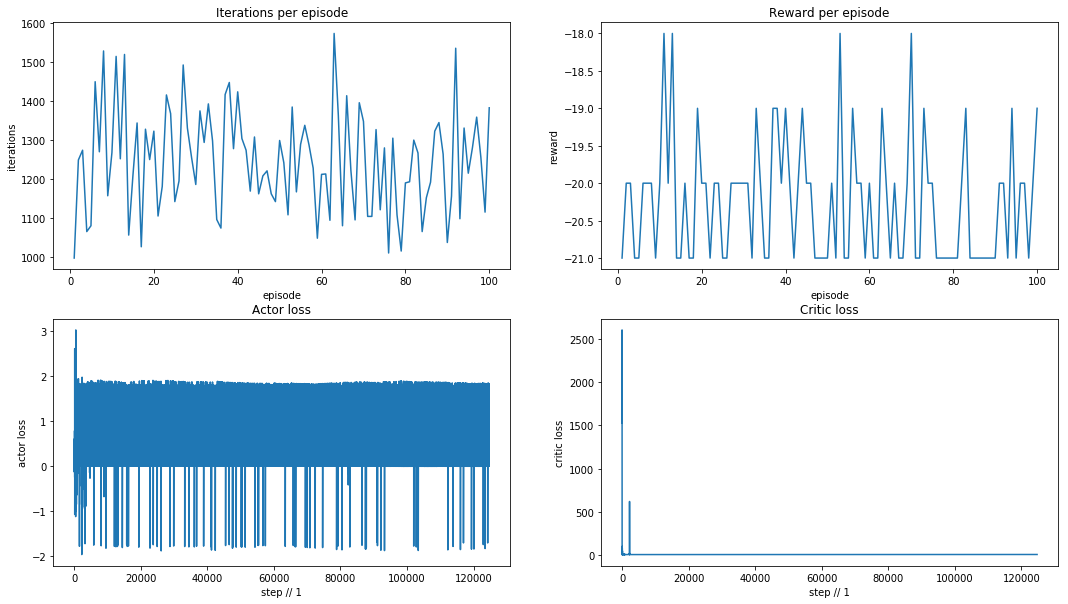

In [10]:
episode_range = np.arange(len(iters_per_episode)) + 1
iter_range = np.arange(len(actor_loss_per_iter)) + 1
steps_to_skip = 1

plt.figure(figsize=(18, 10))
plt.subplot(2, 2, 1)
plt.title('Iterations per episode')
plt.plot(episode_range, iters_per_episode)
plt.ylabel('iterations')
plt.xlabel('episode')

plt.subplot(2, 2, 2)
plt.title('Reward per episode')
plt.plot(episode_range, reward_per_episode)
plt.ylabel('reward')
plt.xlabel('episode')

plt.subplot(2, 2, 3)
plt.title('Actor loss')
plt.plot(iter_range[::steps_to_skip] // steps_to_skip,
         actor_loss_per_iter[::steps_to_skip])
plt.ylabel('actor loss')
plt.xlabel(f'step // {steps_to_skip}')

plt.subplot(2, 2, 4)
plt.title('Critic loss')
plt.plot(iter_range[::steps_to_skip] // steps_to_skip,
         critic_loss_per_iter[::steps_to_skip])
plt.ylabel('critic loss')
plt.xlabel(f'step // {steps_to_skip}')
plt.show()